<h1> Optical character recognition</h1>


In [4]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import math
import os
from shutil import copyfile

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.layers import Flatten

In [14]:
#get the dataset for ocr
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz

--2022-11-18 06:54:49--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49817950 (48M) [application/x-gzip]
Saving to: ‘EnglishFnt.tgz.1’

EnglishFnt.tgz.1    100%[===================>]  47.51M  11.3MB/s    in 4.8s    

2022-11-18 06:54:55 (9.86 MB/s) - ‘EnglishFnt.tgz.1’ saved [49817950/49817950]



In [ ]:
#unzip the dataset
!tar -xvzf EnglishFnt.tgz

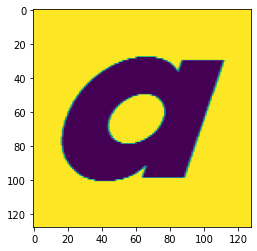

In [16]:
#view an image sample
imgsample = Image.open('./English/Fnt/Sample037/img037-00008.png')
npsample = np.array(imgsample)
plt.imshow(npsample)

<h1>PREPROCESSING</h1>

In [6]:
#create train, valid and test directories
if not os.path.isdir('dataset'):
  os.mkdir('dataset')

if not os.path.isdir('dataset/train'):
  os.mkdir('dataset/train')
if not os.path.isdir('dataset/valid'):
  os.mkdir('dataset/valid')
if not os.path.isdir('dataset/test'):
  os.mkdir('dataset/test')

In [7]:
#make class directories inside them
for i in sorted(os.listdir('English/Fnt')):
  if not os.path.isdir('dataset/train/'+i):
    os.mkdir('dataset/train/'+i)
  if not os.path.isdir('dataset/valid/'+i):
    os.mkdir('dataset/valid/'+i)
  if not os.path.isdir('dataset/test/'+i):
    os.mkdir('dataset/test/'+i)

In [8]:
#split main folder to train, valid, test and copy images to the new folders
base = 'English/Fnt/Sample'

for char  in range(1, 63):
  classLen = len(os.listdir(base + str(char).zfill(3)))

  trainLen = math.floor(classLen*0.80)
  validLen = math.ceil(classLen*0.15)

  randFnt = np.random.randint(low = 1, high = classLen, size = classLen)
  randTrain = randFnt[:trainLen]
  randValid = randFnt[trainLen : trainLen+validLen]
  randTest = randFnt[trainLen+validLen :]

  for imgNo in randTrain:
    src = base+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/train/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randValid:
    src = base+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/valid/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randTest:
    src = base+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/test/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)


<h1>MODEL CREATION</h1>

In [9]:
#define constants
num_classes = 62
image_resize = 128
batch_size_training = 128
batch_size_validation = 64

In [10]:
#create data generator
data_generator = ImageDataGenerator(rescale=1.0/255.0)

In [11]:
#create train and valid generators
train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 34610 images belonging to 62 classes.
Found 8818 images belonging to 62 classes.


In [12]:
#view batch specifications
batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 128, 128, 1), min=0.000, max=1.000


In [13]:
#This is the best model i could create.
#Because for other cases, the improvement was minimal compared to the additional computational cost.

In [14]:
#create the model
def ocrModel():
  model = Sequential()
  model.add(Conv2D(32, (4,4), strides = (1,1), activation = 'relu', input_shape = (128, 128, 1)))
  model.add(MaxPooling2D(pool_size = (4,4), strides = (2,2)))
  model.add(Conv2D(64, (4,4), strides = (1,1), activation = 'relu', input_shape = (128, 128, 1)))
  model.add(MaxPooling2D(pool_size = (4,4),strides = (2,2)))

  model.add(Flatten())

  model.add(Dense(310, activation='relu'))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

  return model

In [15]:
#parameters for fitting
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(train_generator)
num_epochs = 10

In [16]:
model = ocrModel()

#view model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 310)               1

<h1>FIT MODEL</H1>

In [17]:
#fit model
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = steps_per_epoch_validation,
    verbose = 1
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


271/271 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.7182

271/271 [==============================] - 32s 86ms/step - loss: 1.1198 - accuracy: 0.7182 - val_loss: 0.4948 - val_accuracy: 0.8466
Epoch 2/10
271/271 [==============================] - 19s 68ms/step - loss: 0.3915 - accuracy: 0.8722
Epoch 3/10
271/271 [==============================] - 19s 71ms/step - loss: 0.2587 - accuracy: 0.9074
Epoch 4/10
271/271 [==============================] - 22s 81ms/step - loss: 0.1918 - accuracy: 0.9298
Epoch 5/10
271/271 [==============================] - 18s 65ms/step - loss: 0.1650 - accuracy: 0.9393
Epoch 6/10
271/271 [==============================] - 18s 65ms/step - loss: 0.1435 - accuracy: 0.9465
Epoch 7/10
271/271 [==============================] - 19s 70ms/step - loss: 0.1286 - accuracy: 0.9524
Epoch 8/10
271/271 [==============================] - 17s 64ms/step - loss: 0.1177 - accuracy: 0.9558
Epoch 9/10
271/271 [==============================] - 18s 68ms/step - loss: 0.1071 - accuracy: 0.9612
Epoch 10/10
271/271 [==============================

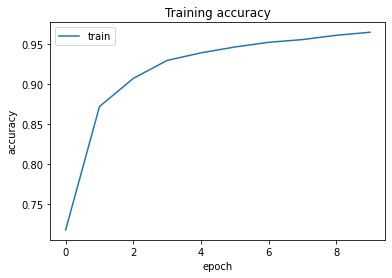

In [23]:
plt.plot(fit_history.history['accuracy'])
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

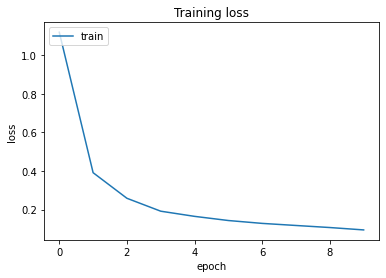

In [22]:
plt.plot(fit_history.history['loss'])
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

<h1>TEST MODEL</h1>

In [24]:
#define test generator
test_generator = data_generator.flow_from_directory(
    'dataset/test',
    target_size = (image_resize, image_resize),
    shuffle = False,
    color_mode='grayscale'
)

Found 3073 images belonging to 62 classes.


In [25]:
#evaluate the model
eval = model.evaluate_generator(test_generator, verbose=1)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

 1/97 [..............................] - ETA: 12s - loss: 0.3598 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


97/97 [==============================] - 2s 16ms/step - loss: 0.2052 - accuracy: 0.9388
Model performance:
loss for test dataset is : 0.20519833266735077
accuracy for test dataset is : 0.9388219714164734


In [2]:
# #connect to your google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# %cd '/content/gdrive/MyDrive/Velozity/character-recognition'

/content/gdrive/MyDrive/Velozity/character-recognition


In [29]:
#save model to google drive
#model.save('OCRmodel.h5')

<h1> TEST MODEL ON OWN FILES</h1>

In [8]:
model_path = '/content/gdrive/MyDrive/Velozity/character-recognition/'
loaded_model = load_model(model_path+'OCRmodel.h5')

In [9]:
#upload files from local storage
from google.colab import files
uploaded = files.upload()

Saving img034-00059.png to img034-00059.png
Saving img059-00010.png to img059-00010.png
Saving img040-00026.png to img040-00026.png
Saving img021-00074.png to img021-00074.png
Saving img001-00097.png to img001-00097.png


In [10]:
#create a label map
classArr = [str(i) for i in range(10)]
classArr.extend([chr(i) for i in range(ord('A'), ord('Z')+1)])
classArr.extend([chr(i) for i in range(ord('a'), ord('z')+1)])

In [11]:
fnames = list(uploaded.keys())

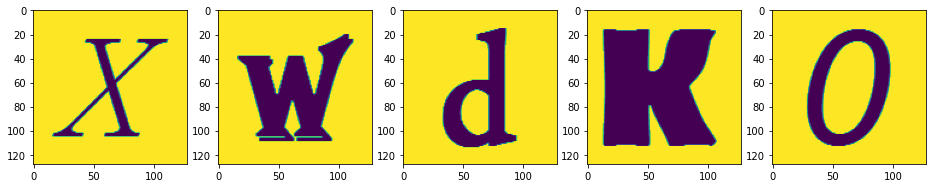

In [12]:
#view the text images to be detected
fig, axs = plt.subplots(1,len(fnames), figsize = (16,5))

for i in range(len(fnames)): 
    image_data = Image.open(fnames[i])
    axs[i].imshow(image_data)

In [13]:
#detect text using model
res = ''
for i in range(len(fnames)):
  img = Image.open(fnames[i])
  imgnp = np.array(img)
  imgnp = np.reshape(imgnp, (1,imgnp.shape[0],imgnp.shape[1], 1))
  predict = np.argmax(loaded_model.predict(imgnp))
  res += classArr[predict]+" "

print(res)

1/1 [==============================] - 0s 14ms/step
X w d K 0 
